# Tutorial for BayBooNE: Baysian Booster Neutrino Experiment python package


This package is designed to use Bayesian parameter estimation to find sterile neutrino oscillation parameters ($\Delta m_{14}^2, sin^2 2\theta_{14}$) from a data sample containing initial muon neutrino flux and number of electron neutrinos detected at a particular neutrino energy.

To do so, we first simulate a short-baseline neutrino oscillation dataset for a particular ($\Delta m^2, sin^2 2\theta$) pair, and then use a pymc3-based algorithm to infer the parameters from our simulated data.

In [37]:
# Pacakge dependencies and data visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns

# Inference package componenets
from bayboone.data_io import Data, OscProbability
from bayboone.inference import module as ifunc

## Create a sample dataset by simulating data based on short baseline experiments.

Our simulation draws from known values of neutrino energy E, distance from detector L, to calculate $\nu_\mu$ to $\nu_e$ oscillation probability, and then adjusts for overall flux (in progress). 

Importantly, we use $$ P_{\nu_{\mu} -> \nu_{e-}} = sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E})$$ to get the oscillation probability, and then simulate a certain number of muon neutrinos which randomly oscillate to electron neutrinos based on the $P_{\nu_{\mu} -> \nu_{e-}}$ for the neutrino.

To simulate data from the microboone experiment, input the number of muon neutrinos you would like to simulate being shot at the detector (N_numu), and the oscillation parameters (ss2t, dms) into the simulate_microboone funtcion like so:

In [2]:
N_numu = 600000
ss2t = 0.5
dms = 0.8
uboone_data = Data.simulate_microboone(N_numu, ss2t, dms)

Data:  600000 83126


If you would rather simulate a different neutrino experiment than microboone, you can use the simulate_detector function, where you can additionally input the baseline or how far the muon neutrinos travel (L), energy of the muon neutrinos (E), and the uncertainty on L and E.

In [21]:
N_numu = 100000
ss2t = 0.7
dms = 10e-3
L = 4.0 # km
E = 1.0 # GeV
sigma_L = 0.1
sigma_E = 0.1
generic_data = Data.simulate_detector(N_numu, ss2t, dms, L, E, sigma_L, sigma_E)

Data:  100000 167


Our simulation gives us the number muon neutrinos shot at the detector (N_numu) and the number of muon neutrinos that oscillated to electron neutrinos (N_Nue)

In [8]:
print('N_numu = '+str(uboone_data.N_numu)+', N_nue = '+str(uboone_data.N_nue))

N_numu = 600000, N_nue = 83126


Text(0.5, 0, 'L')

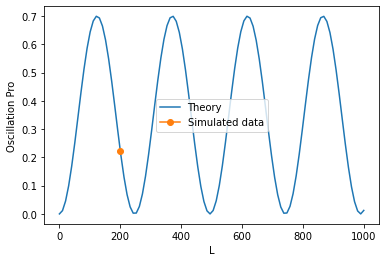

In [36]:
L_array = np.linspace(0.1,1000, 100)
plt.plot(L_array, OscProbability(ss2t, dms, L_array, E), label='Theory')
plt.plot(200, OscProbability(ss2t, dms, 200, E), marker='o', label='Simulated data')
plt.legend()
plt.ylabel('Oscillation Pro')
plt.xlabel('L')


## Infer $\Delta m^2$ and $sin^2 2\theta$ from our simulated data.

We make use of three functions from our inference_functions pacakge (imported here as ifunc):

-  oscillation_model: sets up our model in pymc3
-  fit_model: fits data to the statistical model
-  print_fit_vals: prints the quartile intervals for the fits on our mixing parameters

Our statistical model for predicting how many electron neutrinos appear is given by:

\begin{align}
    sin^2(2\theta) &\sim \text{Uniform(0.0001, 1)} \\
    \Delta m^2 &\sim \text{Jeffreys(0.01, 10)} \\
    L &\sim \text{Truncated Normal}(\mu = 0.5, \sigma = 0.05) \\
    E &\sim \text{Truncated Normal}(\mu = 1.0, \sigma = 0.05) \\
    \text{rate} &= \#\nu_{mu}sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E}) \\
    \#\nu_{e-} &\sim \text{Poisson}(\mu = \text{rate})
\end{align}
We're treating the distributions of L and E as priors rather than known parameters due to their associated uncertainties - based on the way neutrinos beams produce neutrinos, both distance travelled and energy is variable.


Pymc3 transforms some of these distributions for ease of computation, so the pymc3 model used is printed by the next cell.

In [38]:
ifunc.oscillation_model(600000, 10)

Now we're going to use our package to do basic MCMC inference on the neutrino mixing parameters. We'll treat L and E as nuisance parameters for this project. This example data corresponds to dms = 0.8 eV^2, ss2t = 0.5.

In [39]:
data = [60000, 2]
trace = ifunc.fit_model(data[0], data[1])

KeyError: 'Some start parameters do not appear in the model!\nValid keys are: L_interval__, L, E_lowerbound__, E, sin^2_2theta_interval__, sin^2_2theta, delta_m^2_interval__, delta_m^2, rate, nue_flux, but log_delta_m^2 was supplied'

Now, let's take our output and look at the marginalized distributions of $sin^2(2\theta)$ and $\Delta m^2$

In [3]:
df_trace = pm.trace_to_dataframe(trace)
df_trace['delta_m^2'] = np.exp(df_trace['log_delta_m^2'])

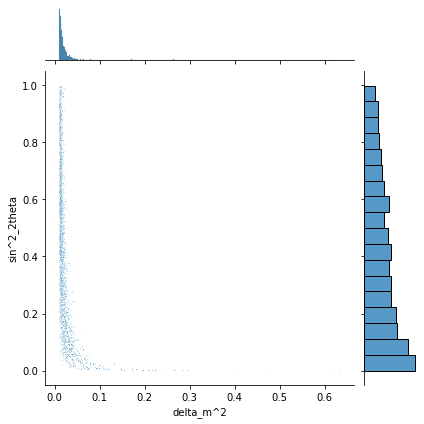

In [4]:
joint_kde = sns.jointplot(x='delta_m^2', y='sin^2_2theta', data=df_trace, kind='scatter', s=0.2)

As a final step, we'll take a look at the quartile intervals of the posterior distributions for our mixing parameters.

In [5]:
ifunc.print_fit_vals(trace)

delta_m^2 = 0.02 + 0.02 - 0.00
sin^2_2theta = 0.3 + 0.4 - 0.3


True

While the quartile ranges for the estimates on $\Delta m^2$ and $sin^2(2\theta)$ include the values we used to generate data, they're so large as to not be too useful yet. This is to a large extent an effect of the high correlation between the two mixing parameters. We're working on finding an appropriate reparameterization of the model that avoids these pitfalls.